# 捨て牌モデルを作成する

- 2入力1出力のモデルを作る
  - 入力: 自分の手牌、相手の捨て牌
  - 出力: 自分の切り牌

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization, Concatenate, Conv1D, Conv2D, Dense, Flatten
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model

## データの読み込み

In [2]:
def tf_to_array(example):
    features = tf.io.parse_single_example(
        example,
        features={
            'player_hands': tf.io.FixedLenFeature([], dtype=tf.string),
            'enemy_discards': tf.io.FixedLenFeature([], dtype=tf.string),
            'player_discard': tf.io.FixedLenFeature([], dtype=tf.string)
        }
    )

    player_hands = tf.io.parse_tensor(features['player_hands'], out_type=tf.float64)
    enemy_discards = tf.io.parse_tensor(features['enemy_discards'], out_type=tf.float64)
    discard_target = tf.io.parse_tensor(features['player_discard'], out_type=tf.float32)

    # type cast and define train and test
    trains = {}
    # trains['player_hands'] =  tf.expand_dims(tf.cast(player_hands, tf.uint8), 0)
    # trains['enemy_discards'] = tf.expand_dims(tf.cast(enemy_discards, tf.uint8), 0)
    # discard_target = tf.cast(discard_target, tf.uint8)

    trains['player_hands'] =  tf.expand_dims(tf.expand_dims(player_hands, 0), 0)
    trains['enemy_discards'] = tf.expand_dims(enemy_discards, 0)
    # discard_target = tf.cast(discard_target, tf.uint8)


    return trains, discard_target

In [3]:
discard_dataset = tf.data.TFRecordDataset(['../data/mahjong_discard_dataset_1000games_20210708.tfrecord'])
parsed_discard_dataset = discard_dataset.map(tf_to_array)

## データセットの分割

In [4]:
DATASET_SIZE = 512387

In [5]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

all_dataset = parsed_discard_dataset.shuffle(int(DATASET_SIZE * 1.2))

train_dataset = all_dataset.take(train_size)
test_dataset = all_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)


## モデルの構築

In [6]:
# data configuration
player_input = (1, 4, 34) # 手牌13枚 * 34種類の牌
enemy_input = (3, 4, 34) # 他家3名 * Max24枚の捨て牌 * 34種類の牌
n_classes = 34 # 捨て牌34種類

In [7]:
# tf Graph input 
input_x1 = Input(player_input, name='player_hands') 
input_x2 = Input(enemy_input, name='enemy_discards') 

# player hands network
x1 = Conv2D(256, (3, 1), activation='relu', padding='same', name='player_hands_weight_1')(input_x1)
x1 = BatchNormalization()(x1)

for i in range(2, 7, 2):
    x1_tmp = Conv2D(256, (3, 1), activation='relu', padding='same', name=f'player_hands_weight_{i}')(x1)
    x1_tmp = BatchNormalization()(x1_tmp)
    x1_tmp = Conv2D(256, (3, 1), activation='relu', padding='same', name=f'player_hands_weight_{i+1}')(x1_tmp)
    x1_tmp = BatchNormalization()(x1_tmp)
    x1 = tf.keras.layers.Add()([x1, x1_tmp])

x1 = Flatten()(x1)

# enemy discards network
x2 = Conv2D(256, (3, 1), activation='relu', padding='same', name='enemy_discards_weight_1')(input_x2)
x2 = BatchNormalization()(x2)

for i in range(2, 7, 2):
    x2_tmp = Conv2D(256, (3, 1), activation='relu', padding='same', name=f'enemy_discards_weight_{i}')(x2)
    x2_tmp = BatchNormalization()(x2_tmp)
    x2_tmp = Conv2D(256, (3, 1), activation='relu', padding='same', name=f'enemy_discards_weight_{i+1}')(x2_tmp)
    x2_tmp = BatchNormalization()(x2_tmp)
    x2 = tf.keras.layers.Add()([x2, x2_tmp])

x2 = Flatten()(x2)

# concatnate network
concatted_x = Concatenate()([x1, x2])

# Affine network
x = Dense(512, activation='relu', name='common_discards_weight_1')(concatted_x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu', name='common_discards_weight_2')(x)
x = BatchNormalization()(x)

# tf Graph output
output_x = Dense(34, activation='softmax')(x)

model = Model(inputs=(input_x1, input_x2), outputs=output_x)


In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
player_hands (InputLayer)       [(None, 1, 4, 34)]   0                                            
__________________________________________________________________________________________________
enemy_discards (InputLayer)     [(None, 3, 4, 34)]   0                                            
__________________________________________________________________________________________________
player_hands_weight_1 (Conv2D)  (None, 1, 4, 256)    26368       player_hands[0][0]               
__________________________________________________________________________________________________
enemy_discards_weight_1 (Conv2D (None, 3, 4, 256)    26368       enemy_discards[0][0]             
______________________________________________________________________________________________

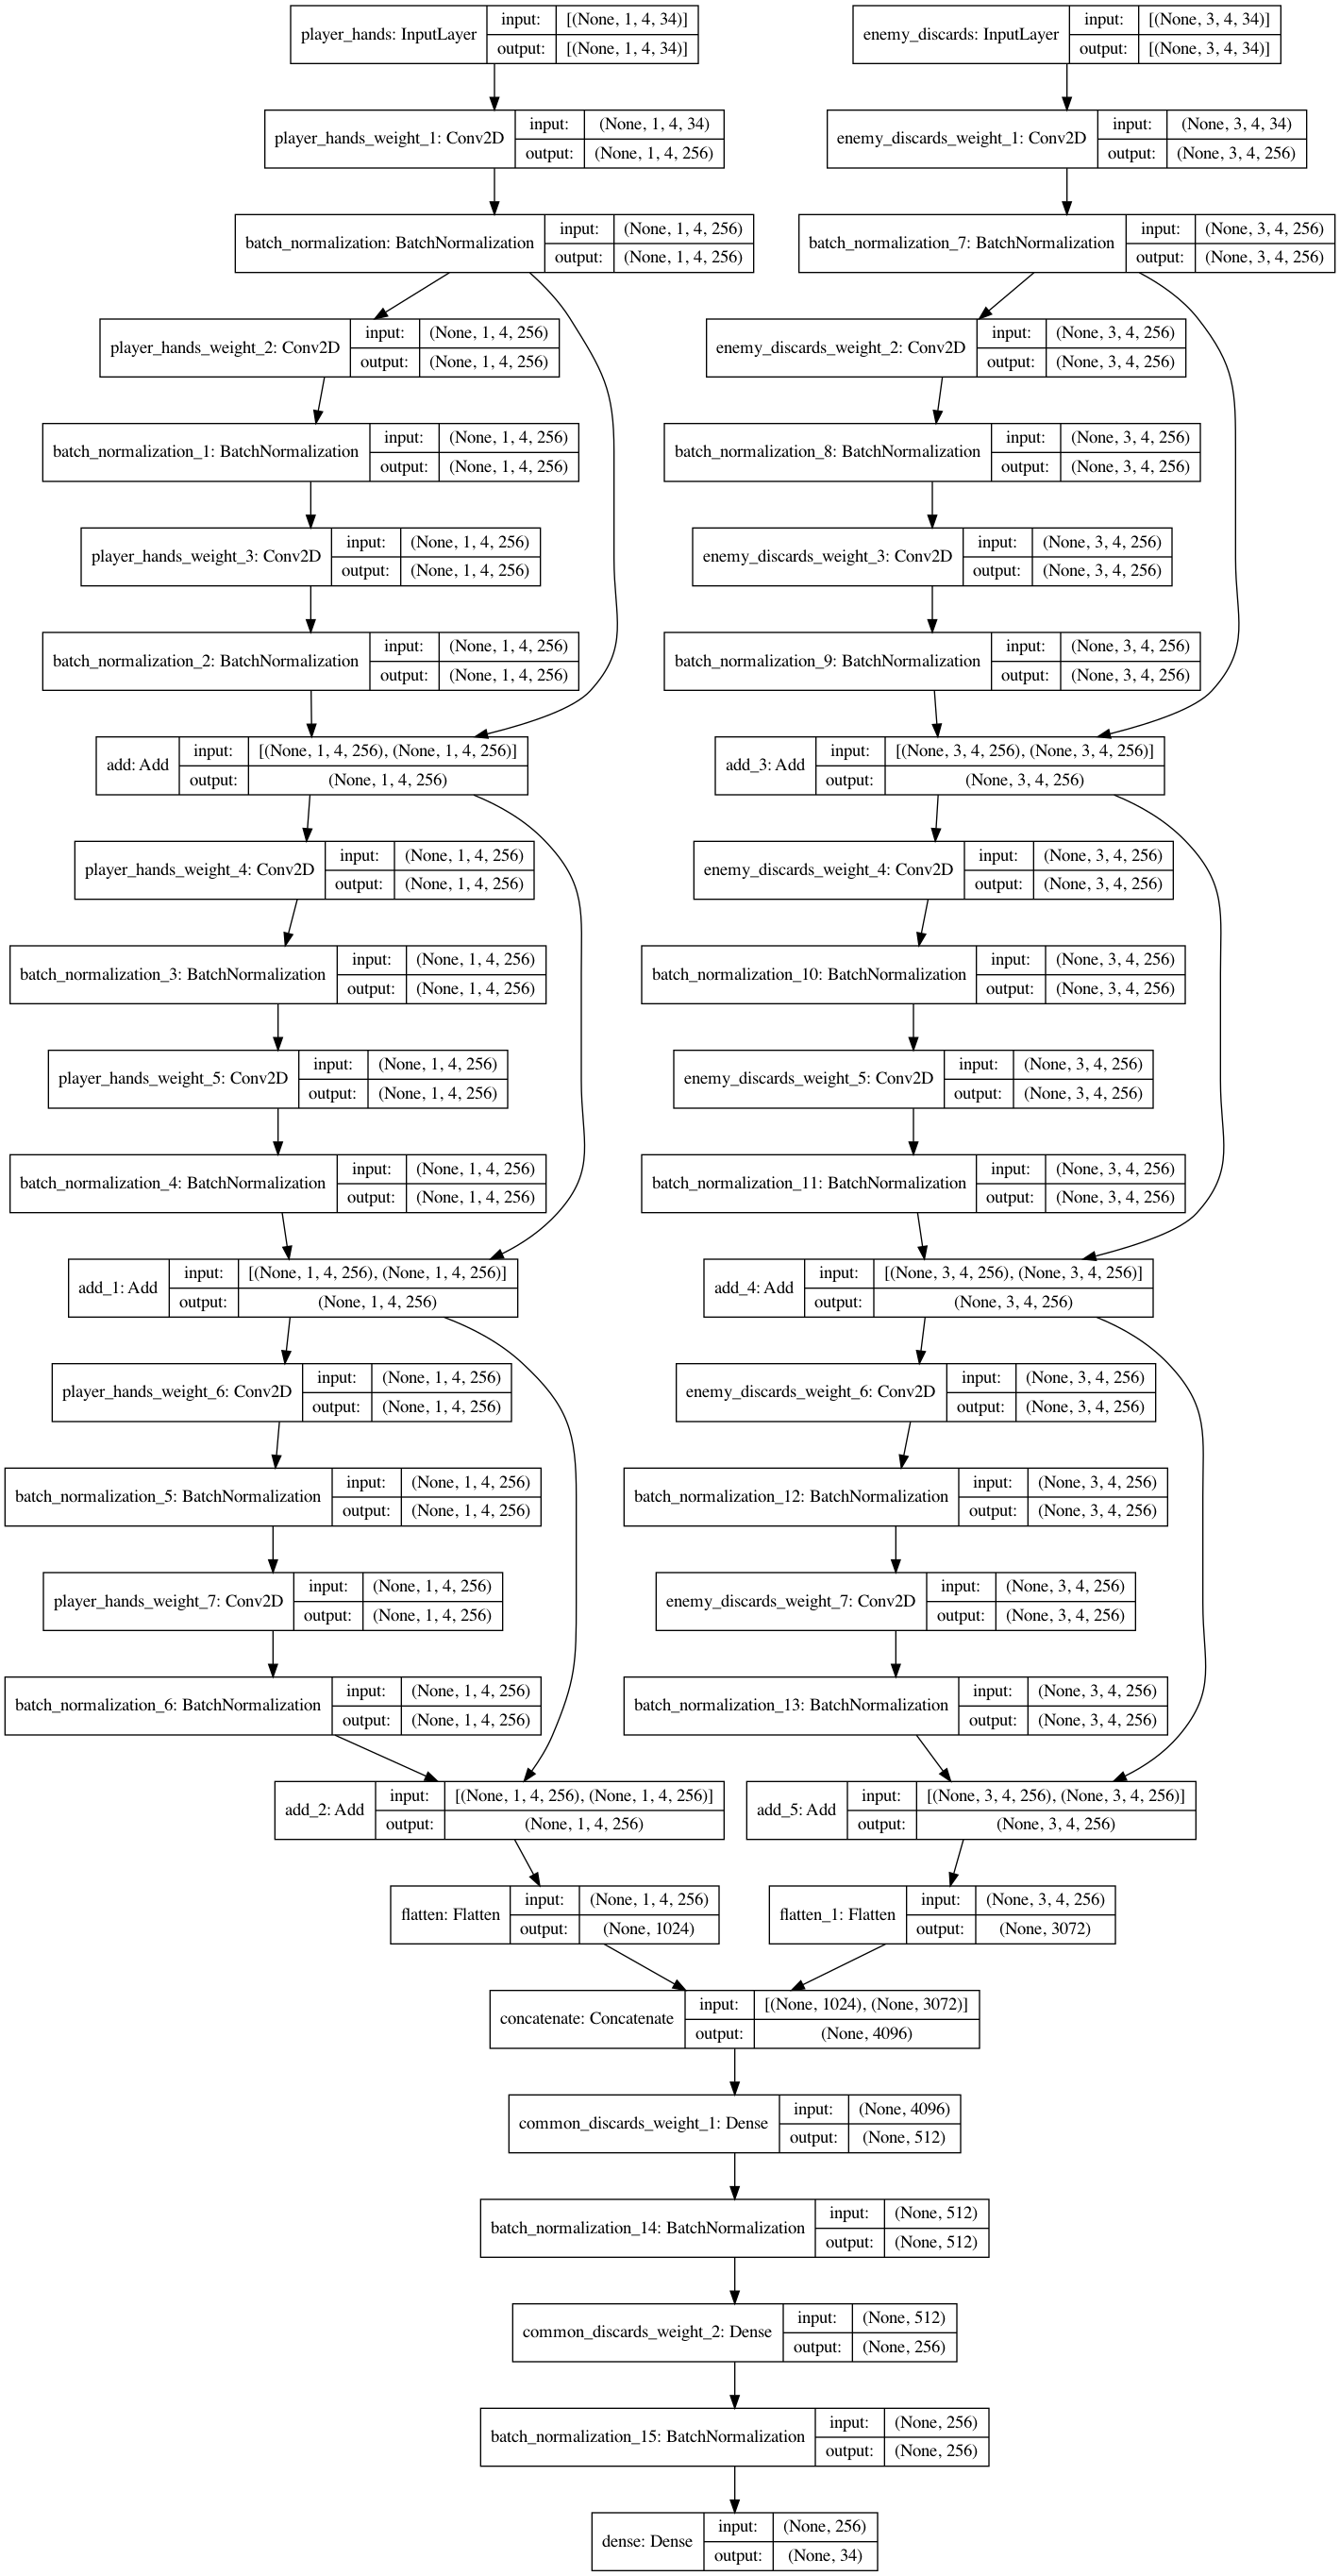

In [9]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

## モデルのコンパイル

In [10]:
model.compile(
    # optimizer=RMSprop(learning_rate=1e-4),  # Optimizer
    optimizer=Adam(learning_rate=1e-3),  # Optimizer
    loss=CategoricalCrossentropy(),
    metrics=Accuracy(),
)

## 学習

In [11]:
epochs = 3
batch_size = 64
steps_per_epoch_train = (train_size - 1) // batch_size + 1
steps_per_epoch_val  = (val_size - 1) // batch_size + 1

In [12]:
# 途中のモデルを保存しておく
cp_cb = ModelCheckpoint(
    filepath="../weights/weights.{epoch:02d}-{loss:.4f}-{val_loss:.4f}.hdf5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="auto"
)

## ToDo:

- accuracy 0 で val_acc が 0.9 なのはなぜ

In [14]:
# 学習
model.fit(
    x=train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    verbose=1,
    shuffle=True,
    steps_per_epoch=steps_per_epoch_train,
    validation_steps=steps_per_epoch_val,
    callbacks=[cp_cb]
)

Epoch 1/3
5605/5605 [==============================] - 165s 28ms/step - loss: 3.4567 - accuracy: 0.0000e+00 - val_loss: 15.8762 - val_accuracy: 0.9394

Epoch 00001: val_loss improved from inf to 15.87622, saving model to ../weights/weights.01-3.4567-15.8762.hdf5


/Users/intel0tw5727/.pyenv/versions/3.9.1/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/3
5605/5605 [==============================] - 159s 28ms/step - loss: 3.4611 - accuracy: 0.0000e+00 - val_loss: 15.7421 - val_accuracy: 0.9403

Epoch 00002: val_loss improved from 15.87622 to 15.74207, saving model to ../weights/weights.02-3.4611-15.7421.hdf5
Epoch 3/3
5605/5605 [==============================] - 152s 27ms/step - loss: 3.4537 - accuracy: 0.0000e+00 - val_loss: 15.7152 - val_accuracy: 0.9401

Epoch 00003: val_loss improved from 15.74207 to 15.71523, saving model to ../weights/weights.03-3.4537-15.7152.hdf5


## 予測

In [16]:
result = model.predict(test_dataset)

In [26]:
import tensorflow_datasets as tfds

In [28]:
np_test_data = tfds.as_numpy(test_dataset)

In [34]:
for i, tmp in enumerate(np_test_data):
    if i == 0:
        player_hands = tmp[0]['player_hands']
        enemy_discards = tmp[0]['enemy_discards']
        target = tmp[1]
        print(player_hands)
        print(target)


[[[[1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0.
    1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
    1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
    0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
    0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [17]:
result[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)